In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
%pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [6]:
train_data_dir='training_set/training_set'
test_data_dir='test_set/test_set'

In [7]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [8]:
data=CatsDogs(train_data_dir)

tensor([0.], device='cuda:0')


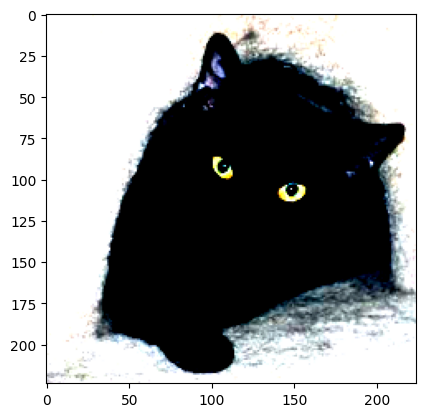

In [9]:
im, label=data[200]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [10]:
#@ Creating model:
def get_model():
  model=models.resnet18(weights=True)
  for param in model.parameters():
    param.requires_grad=False
  model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1, 1))
  model.fc=nn.Sequential(nn.Flatten(),
                         nn.Linear(512, 128),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(128, 1),
                         nn.Sigmoid())

  loss_function=nn.BCELoss()
  optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
  return model.to(device), loss_function, optimizer

In [11]:
!pip install torchsummary
from torchsummary import summary

model, criterion, optimizer=get_model()
summary(model, (3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
#@ Batch training:
def batch_train(x, y, model, opt,  loss_function):
  model.train()
  prediction=model(x)
  batch_loss=loss_function(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [19]:
#@ Calculating accuracy:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction=model(x)
  is_correct=(prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [20]:
#@ Getting Data:
def get_data():
  train=CatsDogs(train_data_dir)
  train_dl=DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
  val=CatsDogs(test_data_dir)
  val_dl=DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return train_dl, val_dl

In [28]:
train_dl, val_dl = get_data()
model, loss_function, optimizer= get_model()

In [25]:
train_losses, train_accuracies=[], []
val_accuracies=[]

for epoch in range(5):
  print(f'epoch{epoch +1}/5')
  train_epoch_losses, train_epoch_accuracies=[], []
  val_epoch_accuracies=[]

  for ix, batch in enumerate(iter(train_dl)):
    x, y= batch
    batch_loss=batch_train(x, y, model, optimizer, loss_function)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss=np.array(train_epoch_losses).mean()


  for ix, batch in enumerate(iter(train_dl)):
    x, y= batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy=np.mean( train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    is_correct=accuracy(x, y, model)
    val_epoch_accuracy=np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch1/5
epoch2/5
epoch3/5
epoch4/5
epoch5/5


ValueError: x and y must have same first dimension, but have shapes (5,) and (155,)

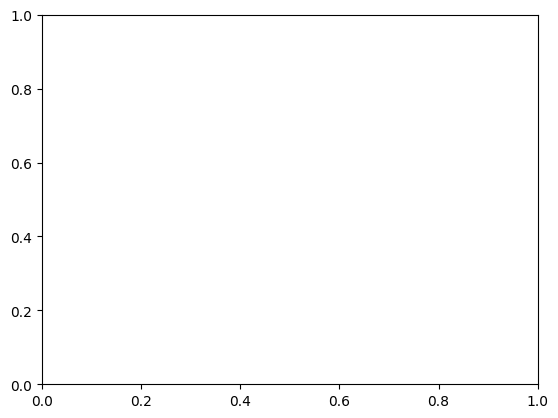

In [33]:

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()